In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pymc as pm
import pymc_experimental as pmx

In [2]:
from pymc_experimental.gp import HSGP, ProjectedProcess, KarhunenLoeveExpansion
from pymc_experimental.gp.latent_approx import ExpQuad, Matern52, Matern32, Matern12

In [3]:
eta_t = 1.0
ell_t = 1.0
cov_t = eta_t**2 * pm.gp.cov.ExpQuad(1, ls=ell_t)

x = np.linspace(0, 20, 100)
f = np.random.multivariate_normal(np.zeros(len(x)), cov_t(x[:, None]).eval(), 1).flatten()

sigma_t = 0.1
y = f + sigma_t * np.random.randn(len(x))

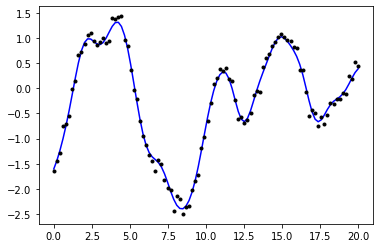

In [4]:
plt.plot(x, f, color='b');
plt.plot(x, y, 'k.');

# Karhunen Loeve Expansion

In [5]:
%%time

with pm.Model() as model:
    eta = eta_t
    ell = ell_t
    cov = eta**2 * pm.gp.cov.ExpQuad(1, ls=ell)
    gp = KarhunenLoeveExpansion(n_eigs=15, cov_func=cov)
    
    f = gp.prior("f", X=x[:, None])
    
    sigma = pm.HalfNormal("sigma", sd=1)
    pm.Normal("lik", mu=f, sd=sigma, observed=y)
    
with model:
    tr = pm.sample(target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/bill/miniconda3/envs/hsgp/lib/python3.10/site-packages/pymc/model.py:984: FutureWarning: `Model.initial_point` has been deprecated. Use `Model.recompute_initial_point(seed=None)`.
  warnings.warn(
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [_gp_f_coefs, sigma]
/home/bill/miniconda3/envs/hsgp/lib/python3.10/site-packages/pymc/model.py:984: FutureWarning: `Model.initial_point` has been deprecated. Use `Model.recompute_initial_point(seed=None)`.
  warnings.warn(


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 2 seconds.


CPU times: user 6.04 s, sys: 2.61 s, total: 8.65 s
Wall time: 6.4 s


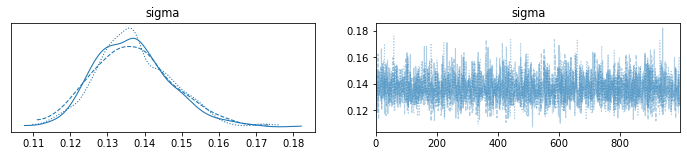

In [6]:
pm.plot_trace(tr, var_names=['sigma']);

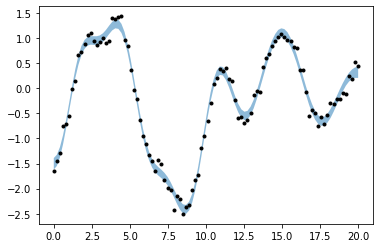

In [7]:
f = tr.posterior['f'].stack({"f": ["chain", "draw"]}).values
upper = np.percentile(f, 95, axis=1)
lower = np.percentile(f, 5, axis=1)

plt.plot(x, y, 'k.');
plt.fill_between(x, lower, upper, alpha=0.5);

# Projected Process / DTC

In [8]:
%%time

with pm.Model() as model:
    eta = pm.HalfNormal('eta', sd=1)
    ell = pm.Gamma('ell', alpha=2, beta=1)
    cov = eta**2 * ExpQuad(1, ls=ell)
    gp = ProjectedProcess(n_inducing=15, cov_func=cov)

    f = gp.prior("f", X=x[:, None])
    
    sigma = pm.HalfNormal("sigma", sd=1)
    pm.Normal("lik", mu=f, sd=sigma, observed=y)
    
with model:
    tr = pm.sample(target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/bill/miniconda3/envs/hsgp/lib/python3.10/site-packages/pymc/model.py:984: FutureWarning: `Model.initial_point` has been deprecated. Use `Model.recompute_initial_point(seed=None)`.
  warnings.warn(
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [eta, ell, f_u_rotated_, sigma]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 153 seconds.
The number of effective samples is smaller than 25% for some parameters.


CPU times: user 7.51 s, sys: 227 ms, total: 7.74 s
Wall time: 2min 40s


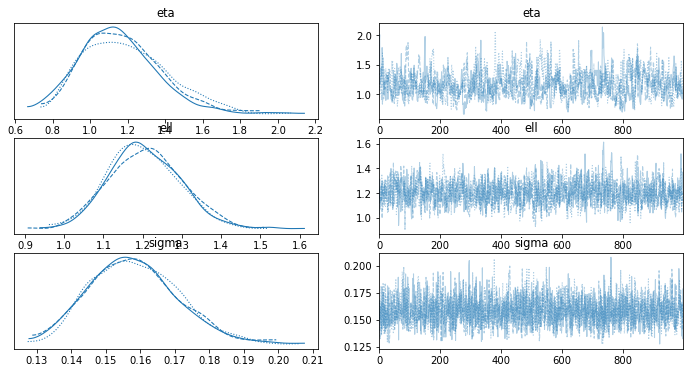

In [9]:
pm.plot_trace(tr, var_names=['eta', 'ell', 'sigma']);

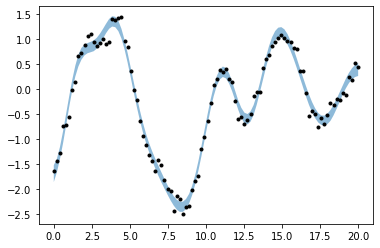

In [10]:
f = tr.posterior['f'].stack({"f": ["chain", "draw"]}).values
upper = np.percentile(f, 95, axis=1)
lower = np.percentile(f, 5, axis=1)

plt.plot(x, y, 'k.');
plt.fill_between(x, lower, upper, alpha=0.5);

# Hilbert Space GP (HSGP)

In [11]:
%%time

with pm.Model() as model:
    eta = pm.HalfNormal('eta', sd=1)
    ell = pm.Gamma('ell', alpha=2, beta=1)
    cov = eta**2 * ExpQuad(1, ls=ell)
    gp = HSGP(n_basis=20, cov_func=cov)
    
    f = gp.prior("f", X=x[:, None])
    
    sigma = pm.HalfNormal("sigma", sd=1)
    pm.Normal("lik", mu=f, sd=sigma, observed=y)
    
with model:
    tr = pm.sample(target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/bill/miniconda3/envs/hsgp/lib/python3.10/site-packages/pymc/model.py:984: FutureWarning: `Model.initial_point` has been deprecated. Use `Model.recompute_initial_point(seed=None)`.
  warnings.warn(
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [eta, ell, f_coeffs_, sigma]
/home/bill/miniconda3/envs/hsgp/lib/python3.10/site-packages/pymc/model.py:984: FutureWarning: `Model.initial_point` has been deprecated. Use `Model.recompute_initial_point(seed=None)`.
  warnings.warn(


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 40 seconds.


CPU times: user 6.09 s, sys: 222 ms, total: 6.31 s
Wall time: 44.3 s


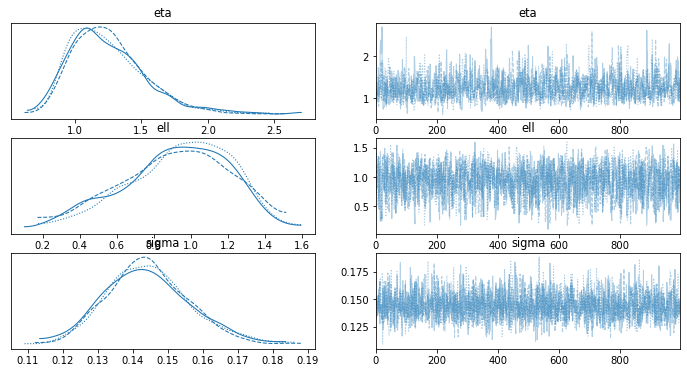

In [12]:
pm.plot_trace(tr, var_names=['eta', 'ell', 'sigma']);

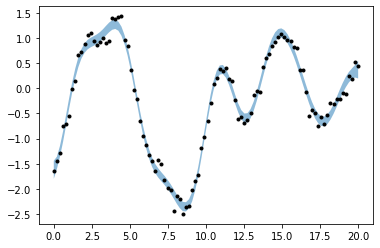

In [13]:
f = tr.posterior['f'].stack({"f": ["chain", "draw"]}).values
upper = np.percentile(f, 95, axis=1)
lower = np.percentile(f, 5, axis=1)

plt.plot(x, y, 'k.');
plt.fill_between(x, lower, upper, alpha=0.5);